In [82]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import skimage as sk
import skimage.io as skio
from skimage.feature import match_template
from skimage.util import img_as_ubyte
import cv2
from skimage.color import rgb2gray

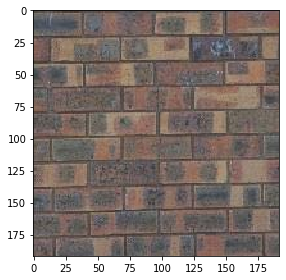

In [75]:
sample = skio.imread('./samples/bricks_small.jpg')
skio.imshow(sample)

In [76]:
np.array(sample.shape)

array([192, 192,   3])

In [77]:
def quilt_random(sample, outsize, patchsize):
    """
    Assume patchsize less than sample size
    """
    w_limit, h_limit, _ = np.array(sample.shape) - patchsize
    ret = np.zeros(outsize)
    for i in range(0, (outsize[0]//patchsize)):
        for j in range(0, (outsize[1]//patchsize)):
            w_rand = np.random.randint(0, w_limit)
            h_rand = np.random.randint(0, h_limit)
            ret[i*patchsize:(i+1)*patchsize,j*patchsize:(j+1)*patchsize,:] = sample[w_rand:w_rand+patchsize,h_rand:h_rand+patchsize,:]
    return ret

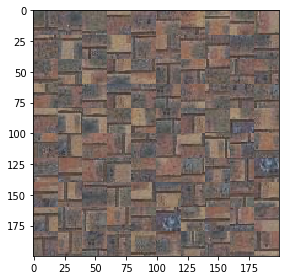

In [83]:
random = quilt_random(sample, (200,200,3), 20)/255
skio.imshow(random)
skio.imsave('./output/random_output.jpg', img_as_ubyte(random))

In [4]:
def find_ssd(im1, im2):
    return sum(sum((im1-im2)**2))
def find_ssd_with_mask(im1, im2, im2_mask):
    return sum(sum(sum(im2_mask*((im1-im2)**2))))

In [5]:
def correspondence_error(source_correspondence, target_correspondence, source_loc, target_loc, patchsize):
    source_x = source_loc[0]
    source_y = source_loc[1]
    target_x = target_loc[0]
    target_y = target_loc[1]
    source_patch = source_correspondence[source_x: source_x + patchsize, source_y: source_y + patchsize]
    target_patch = target_correspondence[target_x: target_x + patchsize, target_y: target_y + patchsize]
    error = find_ssd(source_patch, target_patch)
    return error

In [6]:
def ssd_patch(source, target_loc, patchsize, ret, ret_mask):
    """
    source: the sample image where the patch is found.
    target_loc: the upper left point of 
        target location in the return image where we are trying to find a patch for.
    ret: the return image.
    ret_mask: the mask indicating where in the return image the patch has been placed.
    cost_image: the SSD cost of choosing each patch centered with upper left corner of the image pixel location
    """
    # Create mask
    mask = ret_mask[target_loc[0]:target_loc[0]+patchsize,target_loc[1]:target_loc[1]+patchsize,:]
    template = ret[target_loc[0]:target_loc[0]+patchsize,target_loc[1]:target_loc[1]+patchsize,:] * mask
    
    cost_image = np.zeros((source.shape[0] - patchsize, source.shape[1] - patchsize))
    for i in range(cost_image.shape[0]):
        for j in range(cost_image.shape[1]):
            source_patch = source[i: i + patchsize, j: j + patchsize, :]
            cost_image[i, j] = find_ssd_with_mask(source_patch, template, mask)
    return cost_image

In [7]:
def texture_transfer_ssd_patch(source, target_loc, patchsize, ret, ret_mask, source_correspondence, target_correspondence, alpha):
    # Create mask
    mask = ret_mask[target_loc[0]:target_loc[0]+patchsize,target_loc[1]:target_loc[1]+patchsize,:]
    template = ret[target_loc[0]:target_loc[0]+patchsize,target_loc[1]:target_loc[1]+patchsize,:] * mask
    
    cost_image = np.zeros((source.shape[0] - patchsize, source.shape[1] - patchsize))
    for i in range(cost_image.shape[0]):
        for j in range(cost_image.shape[1]):
            source_patch = source[i: i + patchsize, j: j + patchsize, :]
            block_error = find_ssd_with_mask(source_patch, template, mask)
            corr_error = correspondence_error(source_correspondence, target_correspondence, (i, j), target_loc, patchsize)
            cost_image[i, j] = alpha * block_error + (1 - alpha) * corr_error
    return cost_image

In [8]:
def choose_sample(source, cost_image, patchsize, tol, small_cost_value=10):
    xs, ys = np.unravel_index(np.argsort(cost_image,axis=None), cost_image.shape)
    x_min = xs[0]
    y_min = ys[0]
    
    minc = cost_image[x_min, y_min]
    candidates = [0]
    
    current_cost = minc
    idx = 1
    while current_cost < minc*(1 + tol) and idx < len(xs):
        current_cost = cost_image[xs[idx], ys[idx]]
        if current_cost < minc*(1 + tol):
            candidates.append(idx)
        idx += 1
            
    idx_rand = np.random.randint(0, len(candidates))
    x = xs[candidates[idx_rand]]
    y = ys[candidates[idx_rand]]
    patch = source[x : x+patchsize,y : y+patchsize, :]
    return patch

In [120]:
def quilt_simple(sample, outsize, patchsize, overlap, tol):
    ret = np.zeros(outsize)
    ret_mask = np.zeros(outsize)
    w_limit, h_limit, _ = np.array(sample.shape) - patchsize
    # Randomly sample upper-left corner
    w_rand = np.random.randint(0, w_limit)
    h_rand = np.random.randint(0, h_limit)
    ret[0:patchsize,0:patchsize,:] = sample[w_rand:w_rand+patchsize,h_rand:h_rand+patchsize,:]
    ret_mask[0:patchsize,0:patchsize,:] = 1
    
    # Iterately sample each successive patch
    for i in range(0,(outsize[0]-patchsize)//(patchsize-overlap)+1):
        for j in range(0,(outsize[1]-patchsize)//(patchsize-overlap)+1):
            if i == 0 and j == 0:
                pass
            x = i*(patchsize-overlap)
            y = j*(patchsize-overlap)
            cost_image = ssd_patch(sample, (x,y), patchsize, ret, ret_mask)
            patch = choose_sample(sample, cost_image, patchsize, 10)
            ret[x:x+patchsize,y:y+patchsize,:] = patch
            ret_mask[x:x+patchsize,y:y+patchsize,:] = 1
    return ret

In [10]:
def error_surface(im1, im2):
    """
    Calculate the error surface of im1 and im2, the overlapped region of the 
    current output image and the new patch.
    """
    return np.sum((im1-im2)**2, axis=2)

In [11]:
def minimum_error_horizontal(error_surface):
    """
    Calculate the minimum error given the error_surface.
    """
    minimum_error = np.zeros((error_surface.shape[0], error_surface.shape[1]))
    minimum_error[:, 0] = error_surface[:, 0]
    
    for j in range(1, minimum_error.shape[1]):
        for i in range(minimum_error.shape[0]):
            if i == 0:
                minimum_error[i, j] = error_surface[i, j] + min(1e10, minimum_error[i, j - 1], minimum_error[i + 1, j - 1])
            elif i == minimum_error.shape[0] - 1:
                minimum_error[i, j] = error_surface[i, j] + min(minimum_error[i - 1, j - 1], minimum_error[i, j - 1], 1e10)
            else:
                minimum_error[i, j] = error_surface[i, j] + min(minimum_error[i - 1, j - 1], minimum_error[i, j - 1], minimum_error[i + 1, j - 1])
    
    return minimum_error

In [12]:
def minimum_cut_horizontal(minimum_error):
    """
    Calculate the minimum cut given the minimum_error.
    """
    pixel_index = np.zeros(minimum_error.shape[1])
    pixel_index[-1] = int(np.argsort(minimum_error[:, -1])[0])
    for i in range(minimum_error.shape[1] - 2, -1, -1):
        li = int(pixel_index[i + 1])
        if li == 0:
            ci = np.argsort(np.array([minimum_error[li, i], minimum_error[li + 1, i]]))[0] + li
        elif li == minimum_error.shape[0] - 1:
            ci = np.argsort(np.array([minimum_error[li - 1, i], minimum_error[li, i]]))[0] + li - 1
        else:
            ci = np.argsort(np.array([minimum_error[li - 1, i], minimum_error[li, i], minimum_error[li + 1, i]]))[0] + li - 1
        pixel_index[i] = ci
    return pixel_index

In [13]:
def minimum_cut_mask_horizontal(pixel_index, overlap):
    mask = np.zeros((overlap, len(pixel_index)))
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if i < pixel_index[j]:
                mask[i, j] = 0
            else:
                mask[i, j] = 1

    return mask

In [14]:
def cut_mask_horizontal(ret, patch, x, y, overlap):
    ret_overlap = ret[x: x + overlap , y: y + patch.shape[1], :]
    patch_overlap = patch[: overlap, :, :]
    mask = minimum_cut_mask_horizontal(minimum_cut_horizontal(minimum_error_horizontal(error_surface(ret_overlap, patch_overlap))), overlap)
    return mask

In [15]:
def cut_mask_vertical(ret, patch, x, y, overlap):
    ret_overlap = ret[x: x + patch.shape[0], y: y + overlap, :]
    patch_overlap = patch[:, : overlap, :]
    mask = np.rot90(minimum_cut_mask_horizontal(minimum_cut_horizontal(minimum_error_horizontal(error_surface(np.rot90(ret_overlap, k = 3), np.rot90(patch_overlap, k = 3)))), overlap))
    return mask

In [16]:
def cut_mask(ret, patch, x, y, overlap):
    # horizontal only
    if y == 0:
        mask_overlap = cut_mask_horizontal(ret, patch, x, y, overlap)
        mask_patch = np.vstack([mask_overlap, np.ones((patch.shape[0] - overlap, patch.shape[1]))])
        #mask_ret = np.vstack([np.ones((patch.shape[0] - overlap, patch.shape[1])), -1 * (mask_overlap - 1)])
        mask_ret = -1 * (mask_patch - 1)
    # vertical only
    elif x == 0:
        mask_overlap = cut_mask_vertical(ret, patch, x, y, overlap)
        mask_patch = np.hstack([mask_overlap, np.ones((patch.shape[0], patch.shape[1] - overlap))])
        #mask_ret = np.hstack([np.ones((patch.shape[0], patch.shape[1] - overlap)), mask_overlap])
        mask_ret = -1 * (mask_patch - 1)
    # both
    else:
        mask_overlap_horizontal = np.vstack([cut_mask_horizontal(ret, patch, x, y, overlap), np.ones((patch.shape[0] - overlap, patch.shape[1]))])
        mask_overlap_vertical = np.hstack([cut_mask_vertical(ret, patch, x, y, overlap), np.ones((patch.shape[0], patch.shape[1] - overlap))])
        mask_patch = mask_overlap_horizontal * mask_overlap_vertical
        #mask_ret = -1 * (mask_patch - 1)
        mask_ret = -1 * (mask_patch - 1)
        
    mask_patch = np.stack([mask_patch, mask_patch, mask_patch], axis=2)
    mask_ret = np.stack([mask_ret, mask_ret, mask_ret], axis=2)

    return mask_patch, mask_ret

In [17]:
def new_patch(ret, patch, x, y, overlap, mask_patch, mask_ret):
    """
    Using the mask to return the new patch with seam.
    """
    patchsize = patch.shape[0]
    ret_x = x + overlap - patch.shape[0]
    ret_y = y + overlap - patch.shape[1]
    new_patch = mask_patch * patch
    canvas = np.zeros((patchsize, patchsize, 3))
    masked_patch = mask_patch * patch
    masked_ret = mask_ret * ret[x: x + patchsize, y: y + patchsize, :]
    new_patch = masked_patch + masked_ret
    
    return new_patch

In [18]:
def quilt_cut(sample, outsize, patchsize, overlap, tol):
    ret = np.zeros(outsize)
    ret_mask = np.zeros(outsize)
    w_limit, h_limit, _ = np.array(sample.shape) - patchsize
    # Randomly sample upper-left corner
    w_rand = np.random.randint(0, w_limit)
    h_rand = np.random.randint(0, h_limit)
    ret[0:patchsize,0:patchsize,:] = sample[w_rand:w_rand+patchsize,h_rand:h_rand+patchsize,:]
    ret_mask[0:patchsize,0:patchsize,:] = 1
    
    # Iterately sample each successive patch
    for i in range(0,(outsize[0]-patchsize)//(patchsize-overlap)+1):
        for j in range(0,(outsize[1]-patchsize)//(patchsize-overlap)+1):
            indicator = 1
            if i == 0 and j == 0:
                indicator = 0
            if indicator == 1:
                x = i*(patchsize-overlap)
                y = j*(patchsize-overlap)
                cost_image = ssd_patch(sample, (x,y), patchsize, ret, ret_mask)
                patch = choose_sample(sample, cost_image, patchsize, 10)
                # masks
                mask_patch, mask_ret = cut_mask(ret, patch, x, y, overlap)
                patch = new_patch(ret, patch, x, y, overlap, mask_patch, mask_ret)
                ret[x:x+patchsize,y:y+patchsize,:] = patch
                ret_mask[x:x+patchsize,y:y+patchsize,:] = 1
    return ret

In [19]:
def texture_transfer(sample, source_correspondence, target_correspondence, alpha, outsize, patchsize, overlap, tol):
    ret = np.zeros(outsize)
    ret_mask = np.zeros(outsize)
    w_limit, h_limit, _ = np.array(sample.shape) - patchsize
    # Randomly sample upper-left corner
    w_rand = np.random.randint(0, w_limit)
    h_rand = np.random.randint(0, h_limit)
    ret[0:patchsize,0:patchsize,:] = sample[w_rand:w_rand+patchsize,h_rand:h_rand+patchsize,:]
    ret_mask[0:patchsize,0:patchsize,:] = 1
    
    # Iterately sample each successive patch
    for i in range(0,(outsize[0]-patchsize)//(patchsize-overlap)+1):
        for j in range(0,(outsize[1]-patchsize)//(patchsize-overlap)+1):
            indicator = 1
            if i == 0 and j == 0:
                indicator = 0
            if indicator == 1:
                x = i*(patchsize-overlap)
                y = j*(patchsize-overlap)
                cost_image = texture_transfer_ssd_patch(sample, (x,y), patchsize, ret, ret_mask, source_correspondence, target_correspondence, alpha)
                patch = choose_sample(sample, cost_image, patchsize, 10)
                # masks
                mask_patch, mask_ret = cut_mask(ret, patch, x, y, overlap)
                patch = new_patch(ret, patch, x, y, overlap, mask_patch, mask_ret)
                ret[x:x+patchsize,y:y+patchsize,:] = patch
                ret_mask[x:x+patchsize,y:y+patchsize,:] = 1
    return ret

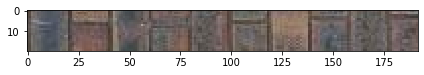

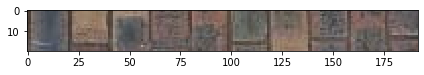

(20, 192)


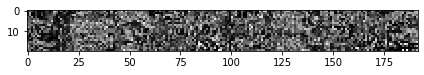

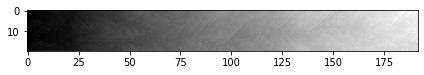

[12. 11. 10. 11. 12. 13. 13. 12. 11. 11. 11. 11. 12. 13. 13. 14. 15. 14.
 15. 14. 15. 16. 17. 16. 17. 17. 16. 16. 15. 15. 14. 15. 15. 16. 16. 15.
 15. 16. 17. 18. 19. 19. 18. 18. 18. 17. 16. 15. 15. 15. 15. 15. 14. 14.
 15. 14. 13. 12. 12. 11. 12. 13. 14. 15. 16. 16. 15. 14. 14. 15. 14. 14.
 14. 13. 12. 11. 11. 12. 11. 12. 11. 12. 13. 14. 14. 15. 15. 16. 17. 18.
 17. 17. 16. 17. 18. 17. 17. 16. 15. 15. 14. 13. 12. 12. 13. 13. 12. 12.
 12. 12. 13. 12. 11. 11. 12. 11. 11. 12. 12. 11. 10. 11. 10. 11. 12. 11.
 11. 11. 12. 12. 11. 12. 11. 11. 11. 11. 12. 12. 12. 11. 10.  9.  8.  7.
  8.  8.  8.  9.  8.  8.  7.  8.  8.  8.  7.  8.  8.  9. 10. 11. 12. 13.
 14. 15. 14. 15. 15. 15. 15. 15. 16. 17. 18. 18. 18. 18. 19. 19. 18. 18.
 19. 19. 19. 18. 18. 18. 18. 17. 16. 16. 16. 16.]


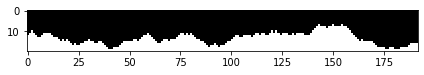

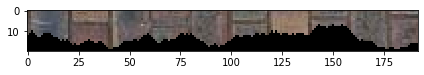

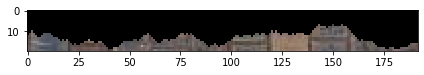

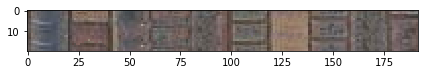

In [146]:
s1 = sample[:, 0:20, :]
s2 = sample[:, 10:30, :]
skio.imshow(np.rot90(s1))
skio.show()
skio.imsave('./output/seam_finding_1.jpg', img_as_ubyte(np.rot90(s1)/255))
skio.imshow(np.rot90(s2))
skio.show()
skio.imsave('./output/seam_finding_2.jpg', img_as_ubyte(np.rot90(s2)/255))
temp = error_surface(np.rot90(s1), np.rot90(s2))
print(temp.shape)
skio.imshow(temp/temp.max())
skio.show()
skio.imsave('./output/error_surface_sample.jpg', img_as_ubyte(temp/temp.max()))
temp2 = minimum_error_horizontal(temp)
skio.imshow(temp2/temp2.max())
skio.show()
skio.imsave('./output/minimum_error_sample.jpg', img_as_ubyte(temp2/temp2.max()))
temp3 = minimum_cut_horizontal(temp2)
print(temp3)
temp4 = minimum_cut_mask_horizontal(temp3, 20)
skio.imshow(temp4)
skio.show()
skio.imsave('./output/seam_sample.jpg', img_as_ubyte(temp4))
mask1 = np.stack([temp4, temp4, temp4], axis=2)
mask2 = -1 * (mask1 - 1)
temp5 = (mask2 * np.rot90(s1))/255
temp6 = (mask1 * np.rot90(s2))/255
skio.imshow(temp5)
skio.show()
skio.imsave('./output/seam_finding_1_seam.jpg', img_as_ubyte(temp5))
skio.imshow(temp6)
skio.show()
skio.imsave('./output/seam_finding_2_seam.jpg', img_as_ubyte(temp6))
skio.imshow(temp5 + temp6)
skio.show()
skio.imsave('./output/seam_finding_output_sample.jpg', img_as_ubyte(temp5 + temp6))

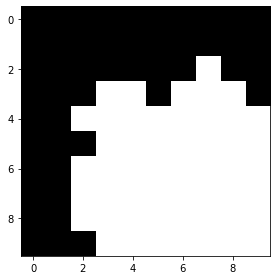

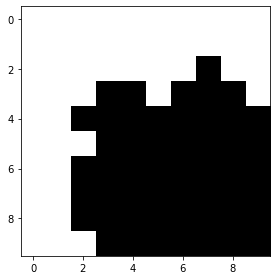

In [155]:
ret = sample[20:40, 20:40, :]
patch = sample[0:10, 0:10, :]
mask_patch, mask_ret = cut_mask(ret, patch, 10, 10, 5)
skio.imshow(mask_patch)
skio.show()
skio.imsave('./output/internal_seam_mask_sample.jpg', img_as_ubyte(mask_patch))
skio.imshow(mask_ret)
skio.show()

In [112]:
quilt_simple_image = quilt_simple(sample, (100,100,3), 9, 3, 0.00001)

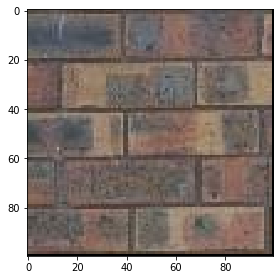

In [114]:
skio.imshow(quilt_simple_image/255)
skio.imsave('./output/quilt_simple_0.00001.jpg', img_as_ubyte(quilt_simple_image/255))

In [117]:
quilt_simple_image_3 = quilt_simple(sample, (100,100,3), 5, 3, 0.3)

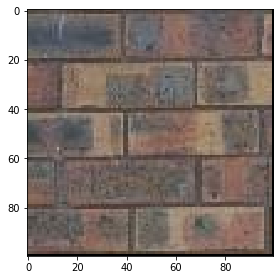

In [119]:
skio.imshow(quilt_simple_image_3/255)
skio.imsave('./output/quilt_simple_0.3.jpg', img_as_ubyte(quilt_simple_image_3/255))

In [127]:
quilt_simple_image_4 = quilt_simple(sample, (100,100,3), 19, 3, 0.01)

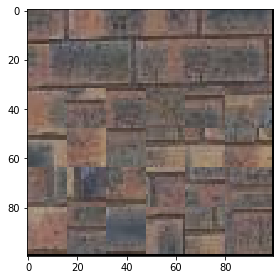

In [130]:
skio.imshow(quilt_simple_image_4/255)
skio.imsave('./output/quilt_simplt_edge_artifacts.jpg', img_as_ubyte(quilt_simple_image_4/255))

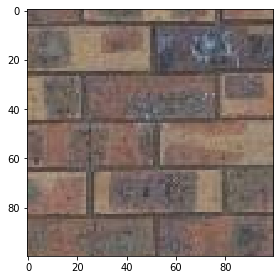

In [147]:
skio.imshow(quilt_simple_image/255)

In [159]:
quilt_cut_image = quilt_cut(sample, (100,100,3), 5, 3, 0.1)

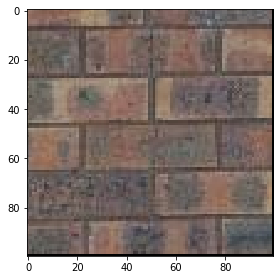

In [162]:
skio.imshow(quilt_cut_image/255)
skio.imsave('./output/quilt_cut_brick.jpg', img_as_ubyte(quilt_cut_image/255))

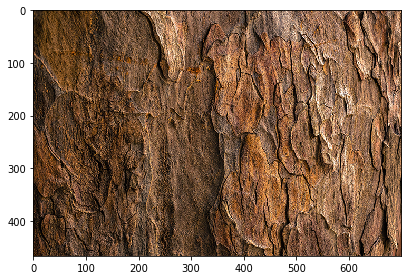

In [164]:
bark = skio.imread('./samples/bark.jpg')
skio.imshow(bark)

In [165]:
bark_out = quilt_cut(bark, (100,100,3), 33, 5, 0.3)

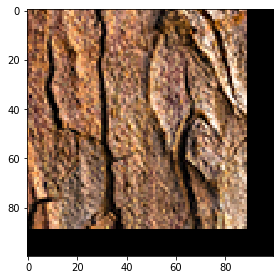

In [167]:
skio.imshow(bark_out/255)
skio.imsave('./output/quilt_cut_bark.jpg', img_as_ubyte(bark_out/255))

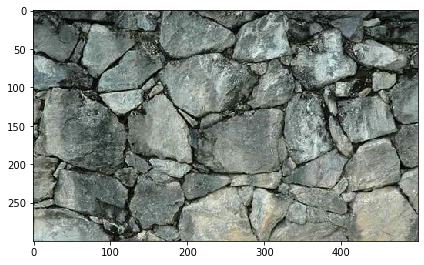

In [168]:
rock = skio.imread('./samples/rock.jpg')
skio.imshow(rock)

In [169]:
rock_out = quilt_cut(rock, (100,100,3), 33, 5, 0.3)

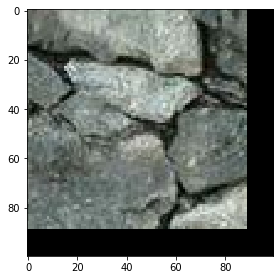

In [174]:
skio.imshow(rock_out/255)
skio.imsave('./output/quilt_cut_rock.jpg', img_as_ubyte(rock_out/255))

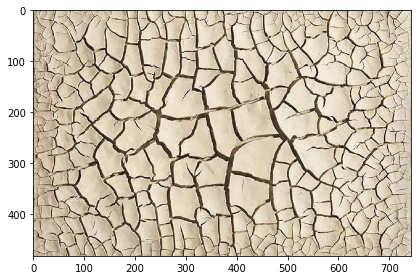

In [171]:
drought = skio.imread('./samples/drought.jpg')
skio.imshow(drought)

In [172]:
drought_out = quilt_cut(drought, (100,100,3), 33, 5, 0.3)

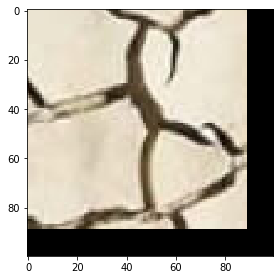

In [176]:
skio.imshow(drought_out/255)
skio.imsave('./output/quilt_cut_drought.jpg', img_as_ubyte(drought_out/255))

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


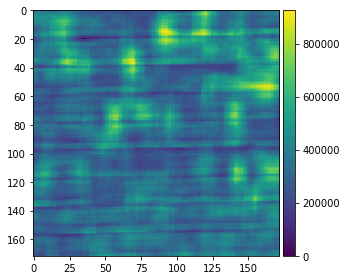

In [139]:
skio.imshow(dst)

In [140]:
patch = choose_sample(sample, dst, 20, 10, small_cost_value=10)

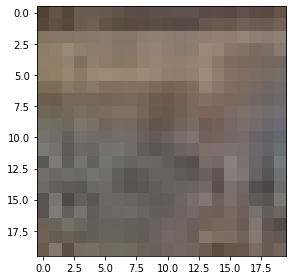

In [141]:
skio.imshow(patch)

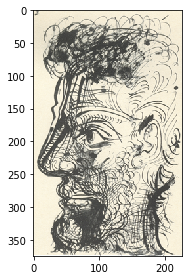

(375, 227, 3)


In [179]:
sketch = skio.imread('./samples/sketch.tiff')
skio.imshow(sketch)
skio.show()
print(sketch.shape)
skio.imsave('./output/texture_transfer_source.jpg', img_as_ubyte(sketch))

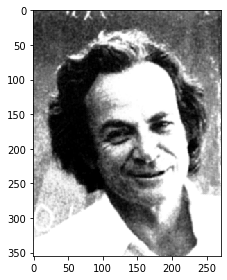

(355, 271, 3)


In [180]:
feynman = skio.imread('./samples/feynman.tiff')
skio.imshow(feynman)
skio.show()
print(feynman.shape)
skio.imsave('./output/texture_transfer_target.jpg', img_as_ubyte(feynman))

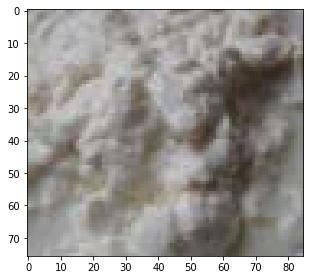

(76, 85, 3)


In [55]:
white = skio.imread('./samples/white_small.jpg')
skio.imshow(white)
skio.show()
print(white.shape)

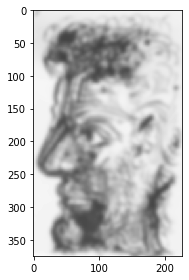

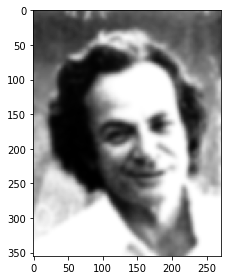

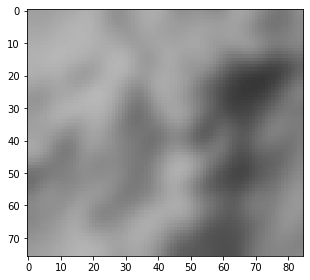

In [56]:
sketch_gray = rgb2gray(sketch)
feynman_gray = rgb2gray(feynman)
white_gray = rgb2gray(white)
sketch_map = sk.filters.gaussian(sketch_gray, sigma=3)
feynman_map = sk.filters.gaussian(feynman_gray, sigma=3)
white_map = sk.filters.gaussian(white_gray, sigma=3)
skio.imshow(sketch_map)
skio.show()
skio.imshow(feynman_map)
skio.show()
skio.imshow(white_map)

In [23]:
texture_out = texture_transfer(sketch, sketch_gray, feynman_gray[100:250, 100:200], 0.1, (150, 100, 3), 9, 3, 0.1)

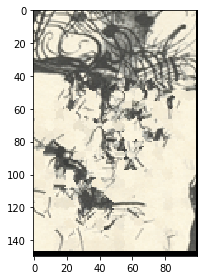

In [181]:
skio.imshow(texture_out/255)
skio.imsave('./output/texture_transfer_out_partial.jpg', img_as_ubyte(texture_out/255))

In [27]:
texture_out_2 = texture_transfer(sketch, sketch_gray, feynman_gray, 0.8, feynman.shape, 33, 5, 0.01)

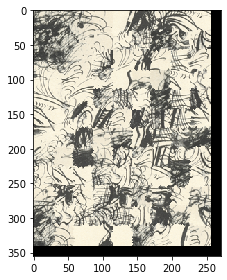

In [182]:
skio.imshow(texture_out_2/255)
skio.imsave('./output/texture_transfer_out.jpg', img_as_ubyte(texture_out_2/255))

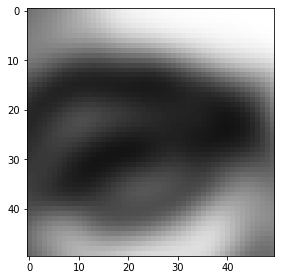

In [185]:
skio.imshow(feynman_map[150:200, 100:150])
skio.imsave('./output/texture_transfer_target_2.jpg', feynman[150:200, 100:150])

In [66]:
texture_out_3 = texture_transfer(white, white_map, feynman_map, 0.1, (50,50,3), 9, 3, 0.1)

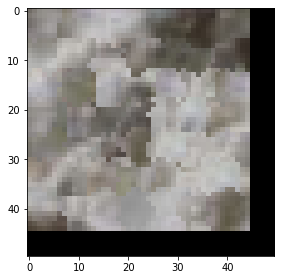

In [187]:
skio.imshow(texture_out_3/255)
skio.imsave('./output/texture_transfer_out_2.jpg', img_as_ubyte(texture_out_3/255))

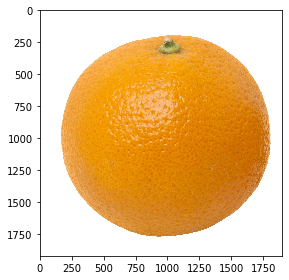

(1920, 1900, 3)


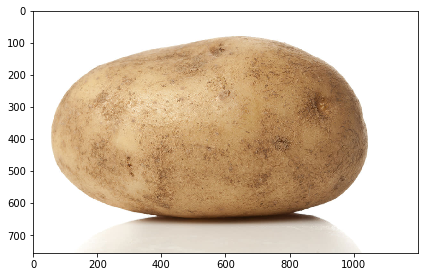

(755, 1200, 3)


In [69]:
orange = skio.imread('./samples/orange.jpg')
potatoe = skio.imread('./samples/potatoe.jpg')
skio.imshow(orange)
skio.show()
print(orange.shape)
skio.imshow(potatoe)
skio.show()
print(potatoe.shape)

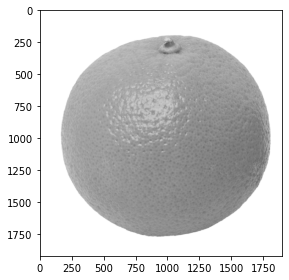

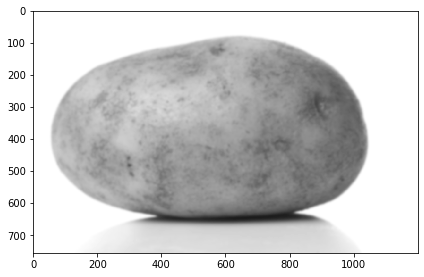

In [72]:
orange_map = sk.filters.gaussian(rgb2gray(orange), sigma=3)
potatoe_map = sk.filters.gaussian(rgb2gray(potatoe), sigma=3)
skio.imshow(orange_map)
skio.show()
skio.imshow(potatoe_map)
skio.show()

In [183]:
texture_out_4 = texture_transfer(orange, orange_map, potatoe_map, 0.1, potatoe.shape, 500, 17, 0.1)

KeyboardInterrupt: 

In [ ]:
skio.imshow(texutre_out_4)